## Code for solving the matching problem.

We need to define four fields which will evolve with the RK scheme.

For the left region we have 3 fields, $\phi_L$, $vp$ and $vm$
For the right region also solve for 3 fields, $S$, $W$, and $\phi_R$.





In [107]:
using Plots
using FileIO
using JLD2
using Base.Threads
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
using LaTeXStrings

nthreads = 2


In [108]:
include("aux_functions.jl")

bump_x (generic function with 1 method)

We have implemented three configurations: 

2 are with L=R=1, one has a bump in L (l_pulse), the other a bump on R, (r_pulse).

The other configuration has a small region for L and a constant size for R. So this is closer to the problem with a cone. 
In this case we keep the number of points in L fixed (and make L smaller with resolution). We need to move slightly the bump so that it is allways in the same place (but shifted in time)

In [109]:
#conv_factor = 1 
#conv_factor = 2
#conv_factor = 3
conv_factor = 4

l_pulse = false
r_pulse = false
c_pulse = false
#r_pulse = true
c_pulse = true

if l_pulse
    run_name = "l_pulse_"
elseif r_pulse
    run_name = "r_pulse_"
elseif c_pulse
    run_name = "c_pulse_"
end

if l_pulse || r_pulse
    Nl = 401; Nr = 401 #points to the left and rigth regions
    L = 1.0 #size of left side 
    R = 1.0 #size of right side
    dl = L/(Nl-1)
    dr = R/(Nr-1)
elseif c_pulse
    Nl = 11; 
    Nr = 400*2^(conv_factor-1) + 1
    R = 2.0 #size of right side
    dr = R/(Nr-1)
    dl = dr 
    L  = dl*(Nl-1)
end

u = zeros(3Nl+3Nr);
ρ_L = zeros(Nl)
ρ_R = zeros(Nr) 

run_name = run_name * "$(Nl)_$(Nr)"
par_grid = (Nl, L, dl, Nr, R, dr)

(11, 0.00625, 0.000625, 3201, 2.0, 0.000625)

### The initial data. 

We shall use first a simple initial data consisting of a bump to the left in the right side. The rest is zero.

In [110]:




if r_pulse
    S = view(u,3Nl+Nr+1:3Nl+2Nr)
    ϕ_R = view(u,3Nl+1:3Nl+Nr)
    x0 = L + 0.2
    x1 = L + 0.4
    p_bump = 4
    A = 1.0
    for i in 1:Nr 
        r = L + dr*(i-1) 
        S[i] = bump_x(r,x0,x1,p_bump,A)
        ϕ_R[i] = bump(r,x0,x1,p_bump,A)
        plot(S)
    end
end

if l_pulse

    x0 =  0.6
    x1 =  0.8
    p_bump = 4
    A = 1.0

    vp = view(u,Nl+1:2Nl)
    ϕ_L = view(u,1:Nl)

    for i in 1:Nl
        r = dl*(i-1) 
        #u[3*Nl+Nr+i] = bump(r,x0,x1,p_bump,A)
        vp[i] = 2*bump_x(r,x0,x1,p_bump,A)
        ϕ_L[i] = bump(r,x0,x1,p_bump,A)
        plot(ϕ_L)
    end
end

if c_pulse
    S = view(u,3Nl+Nr+1:3Nl+2Nr)
    ϕ_R = view(u,3Nl+1:3Nl+Nr)
    x0 = L*2^(conv_factor-1) + 0.2 
    x1 = x0 + 0.2
    p_bump = 4
    A = 1.0
    for i in 1:Nr 
        r = L + dr*(i-1) 
        S[i] = bump_x(r,x0,x1,p_bump,A)
        ϕ_R[i] = bump(r,x0,x1,p_bump,A)
        plot(S)
    end
end

par_init = (x0,x1,p_bump,A)



(0.25, 0.45, 4, 1.0)

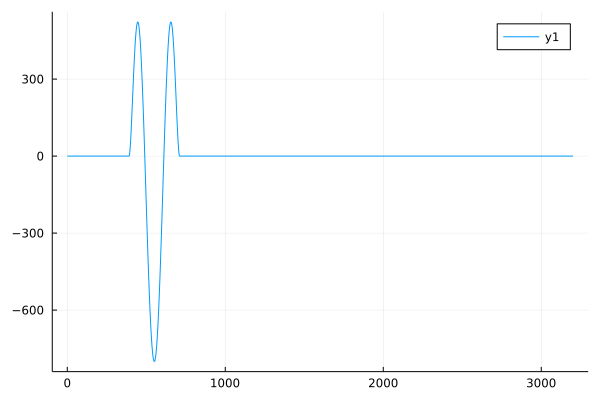

In [111]:
par_Dx_r = (Nr, dr)
dS = D4x_SBP_ts(S,par_Dx_r,Qd)
plot(dS)

In [112]:
ρ_L = zeros(Nl)
ρ_R = zeros(Nr)
du = zeros(3Nl+3Nr)

p_F = Nl, dl, Nr, dr, ρ_L, ρ_R

(11, 0.000625, 3201, 0.000625, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [113]:
t_i = 0.0
if l_pulse
    t_f = 2.0
    M = 1601
    dt = (t_f - t_i)/(M-1)
    M_d = 101
elseif r_pulse
    t_f = 3.0
    M = 1801
    dt = (t_f - t_i)/(M-1)
    M_d = 151
elseif c_pulse 
    t_f = 2.0
    M = (801-1)*2^(conv_factor-1)+1
    dt = (t_f - t_i)/(M-1)
    M_d = 81
end
t = t_i
dt_d = (t_f - t_i)/(M_d-1)

0.025

In [114]:
k1 = zeros(3Nl+3Nr)
k2 = zeros(3Nl+3Nr)
k3 = zeros(3Nl+3Nr)
k4 = zeros(3Nl+3Nr)
par_RK = (k1, k2, k3, k4)
par_evolv = (t_i, t_f, M, dt, M_d, dt_d)

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "par_init" => par_init)
file_name = "Results/"* run_name * ".jld2"
#rm(file_name)
j = 1
tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end

9636-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [115]:


for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_d-1)) == 0
        local j = (k-1)÷(M÷(M_d-1))+1
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end
        println("t=$t")
    end
end


t=0.025000000000000015
t=0.05000000000000004
t=0.07499999999999978
t=0.09999999999999924
t=0.12499999999999871
t=0.1499999999999982
t=0.17499999999999766
t=0.19999999999999712
t=0.2249999999999966
t=0.24999999999999606
t=0.2749999999999955
t=0.299999999999995
t=0.32499999999999446
t=0.3499999999999939
t=0.3749999999999934
t=0.39999999999999286
t=0.42499999999999233
t=0.4499999999999918
t=0.47499999999999126
t=0.49999999999999073
t=0.5249999999999946
t=0.5499999999999985
t=0.5750000000000024
t=0.6000000000000063
t=0.6250000000000102
t=0.6500000000000141
t=0.675000000000018
t=0.7000000000000219
t=0.7250000000000258
t=0.7500000000000298
t=0.7750000000000337
t=0.8000000000000376
t=0.8250000000000415
t=0.8500000000000454
t=0.8750000000000493
t=0.9000000000000532
t=0.9250000000000571
t=0.950000000000061
t=0.9750000000000649
t=1.0000000000000688
t=1.0250000000000639
t=1.0500000000000589
t=1.075000000000054
t=1.100000000000049
t=1.125000000000044
t=1.150000000000039
t=1.175000000000034
t=1.200